In [94]:
import torch
import torch.nn.functional as F
torch.set_printoptions(precision=None, threshold=None, edgeitems=5, linewidth=120, profile='short', sci_mode=False)

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
import networkx as nx


In [95]:
nx_graph = nx.read_gpickle("data/pickles/nx_road_graph.pickle")
print(nx_graph)

Graph with 575 nodes and 574 edges


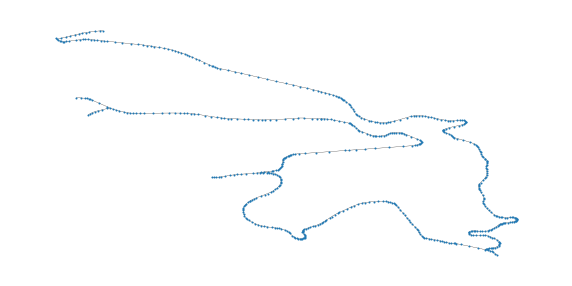

In [105]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(10, 5))

nx.draw(
    G=nx_graph,
    pos={n: nx_graph.nodes[n]['coords'] for n in nx_graph.nodes},
    ax=ax,
    width=0.25,
    node_size=1,
    with_labels=False
    )

In [97]:
torch_graph = from_networkx(nx_graph)
torch_graph

Data(x=[575, 8], edge_index=[2, 1148], y=[575, 2], coords=[575, 2], transl=[575, 2], props=[575, 9], weight=[1148])

In [98]:
torch_graph['props']

tensor([[2677769.79, 1247077.91,     2.00,   200.00,    11.00,     9.19,     2.00,     0.00,     0.00],
        [2677765.02, 1247085.77,     2.00,   200.00,    11.00,     9.19,     2.00,     0.00,     0.00],
        [2677783.55, 1247086.94,     2.00,   200.00,    11.00,   171.90,    12.00,     0.00,     0.00],
        [2677798.60, 1247095.70,     2.00,   200.00,    11.00,   171.90,    12.00,     0.00,     0.00],
        [2677814.88, 1247105.47,     2.00,   200.00,    11.00,   171.90,    12.00,     0.00,     0.00],
        ...,
        [2679240.39, 1245285.77,     2.00,   200.00,    11.00,    64.05,     7.00,     0.00,     0.00],
        [2679233.25, 1245297.83,     2.00,   200.00,    11.00,    64.05,     7.00,     0.00,     0.00],
        [2679229.12, 1245303.71,     2.00,   200.00,    11.00,    64.05,     7.00,     0.00,     0.00],
        [2679224.52, 1245308.31,     2.00,   200.00,    11.00,    64.05,     7.00,     0.00,     0.00],
        [2679216.74, 1245313.23,     2.00,   200.00

In [99]:
torch_graph.num_node_features


8

In [100]:
print('======================')
print(f'Number of nodes: {torch_graph.num_nodes}')
print(f'Number of edges: {torch_graph.num_edges}')
print(f'Number of node features: {torch_graph.num_node_features}')
print(f'Number of edge features: {torch_graph.num_edge_features}')
print(f'Average node degree: {torch_graph.num_edges / torch_graph.num_nodes:.2f}')
print(f'Contains isolated nodes: {torch_graph.has_isolated_nodes()}')
print(f'Contains self-loops: {torch_graph.has_self_loops()}')
print(f'Is undirected: {torch_graph.is_undirected()}')
print('======================')

Number of nodes: 575
Number of edges: 1148
Number of node features: 8
Number of edge features: 0
Average node degree: 2.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [101]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(in_channels=torch_graph.num_node_features, out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=2)

    def forward(self, data):
        x, edge_index = data.x.type(torch.double), data.edge_index.type(torch.double)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = torch_graph.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()